In [ ]:
import os
import sys
from datetime import datetime
sys.path.insert(0, "../../..")
sys.path.insert(0, "../../../../acquire")

from HUGS.Processing import search
from HUGS.Client import Process, Search, Retrieve
from Acquire.ObjectStore import datetime_to_string
from Acquire.Client import User, Drive, Service, PAR, Authorisation, StorageCreds

from HUGS.Client import Search
from HUGS.Util import get_datapath

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy.feature import BORDERS
import cartopy.crs as ccrs
import matplotlib.cm as cm
import xarray as xr
import numpy as np
import json

import ipyleaflet as ipl
import ipywidgets as ipw

from pathlib import Path

# Autoreload modules before executing code, useful during development
%load_ext autoreload
%autoreload 2

Search for some EUROCOM data

In [ ]:
base_url= "https://hugs.acquire-aaai.com/t"
search = Search(service_url=base_url)

In [ ]:
acrg_json = get_datapath(filename="acrg_site_info.json")
with open(acrg_json, "r") as f:
    acrg_sites = json.load(f)

Panel 1 - NOAA with EDGAR

In [ ]:
filepath = "/home/gar/Documents/Devel/hugs/user/notebooks/openghg/ch4-anthro_GLOBAL_2012.nc"

# Here try and work  out projection issues

# filepath = "/home/home/gar/Documents/Devel/RSE/hugs/raw_data/ch4-anthro_GLOBAL_2012.nc"

ds = xr.open_dataset(filepath)

domain = "EUROPE"

lon_name = "lon"
lat_name = "lat"

long_values = ds["flux"][lon_name]
lat_values = ds["flux"][lat_name]
zero_values = ds["flux"][:, :, 0]

In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax = fig.add_subplot(111, projection=ccrs.Mercator(), frameon=False)

ax.coastlines(color="0.2")
ax.add_feature(BORDERS, edgecolor="0.5")

ax.set_extent((-140,-30, -60,80),crs=ccrs.Mercator())

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

cmap = cm.get_cmap("viridis")

levels = np.linspace(np.percentile(ds["flux"].values, 5), np.percentile(ds["flux"].values, 97), 10)

ax.contourf(long_values, lat_values, zero_values, cmap=cmap, transform=ccrs.Mercator(), levels=levels)

fig.savefig("emissions_edgar_NAmerica.png", dpi=600, bbox_inches="tight")

In [ ]:
base_url= "https://hugs.acquire-aaai.com/t"
search = Search(service_url=base_url)

search_terms = ["ch4"]
locations = []

noaa_results = search.search(search_terms=search_terms, locations=locations, data_type="NOAA")

Process some of the results to extract the sites etc

In [ ]:
import ipyleaflet as ipl

center = [-5, 0]
zoom = 2
noaa_map = ipl.Map(center=center, zoom=zoom)

# Load in the ACRG site data
acrg_json = get_datapath(filename="acrg_site_info.json")
with open(acrg_json, "r") as f:
    acrg_sites = json.load(f)

for res in noaa_results:
    site = noaa_results[res]["metadata"]["site"]
    
    site = site.upper()
 
    species = noaa_results[res]["metadata"]["species"]
    start_date = noaa_results[res]["start_date"]
    end_date = noaa_results[res]["end_date"]
    
    # Get the latitude and longitude from the ACRG site info
    # As we don't have all the site data stored we skip a few datasets
    try:
        long = acrg_sites[site]["NOAA"]["longitude"]
        lat = acrg_sites[site]["NOAA"]["latitude"]
        long_name = acrg_sites[site]["NOAA"]["long_name"]

        marker = ipl.Marker(location=(lat, long), draggable=False)
        marker.popup = ipw.HTML(value=f"Site: {long_name} ({site})<br>Species: {species.upper()}<br>Daterange: {start_date} -<br>{end_date}")

        noaa_map.add_layer(marker)
    except:
        pass

# Now we overlay the footprint image. In the future this will be dynamically updated from NetCDF
edgar_image_path = "Emissions_Americas.png"

edgar_layer = ipl.ImageOverlay(url=edgar_image_path, bounds=((-60,-140), (55,-30)))
noaa_map.add_layer(edgar_layer)

    
noaa_map

Map(center=[-5, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

#### A. Map of sites for which NOAA (National Oceanic and Atmospheric Administration) flask data is available. An emissions map for the Americas has been overlain on the map to show methane emissions for these regions.

Panel 2 - EUROCOM with footprint

In [ ]:
euro_search_terms = ["co2"]
euro_locations = []

eurocom_results = search.search(search_terms=euro_search_terms, locations=euro_locations, data_type="EUROCOM")


In [ ]:
center = [54.2361, -4.548]
zoom = 3
eurocom_map = ipl.Map(center=center, zoom=zoom)

for res in eurocom_results:
    site = eurocom_results[res]["metadata"]["site"]
    
    site = site.upper()
 
    species = eurocom_results[res]["metadata"]["species"]
    start_date = eurocom_results[res]["start_date"]
    end_date = eurocom_results[res]["end_date"]
    
    # Get the latitude and longitude from the ACRG site info
    # As we don't have all the site data stored we skip a few datasets
    try:
        # Some sites may not be associated with EUROCOM in acrg_sites
        network_key = list(acrg_sites[site].keys())[0]
        
        long = acrg_sites[site][network_key]["longitude"]
        lat = acrg_sites[site][network_key]["latitude"]
        long_name = acrg_sites[site][network_key]["long_name"]

        marker = ipl.Marker(location=(lat, long), draggable=False)
        marker.popup = ipw.HTML(value=f"Site: {long_name} ({site})<br>Species: {species.upper()}<br>Daterange: {start_date} -<br>{end_date}")

        eurocom_map.add_layer(marker)
    except:
        pass
    
eurocom_map

Map(center=[54.2361, -4.548], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

#### B) Dynamic Map of EUROCOM sites for which data is available. Data for each site is plottable by clicking on the site icon and then pressing the plot button in the bottom left of the map.

In [ ]:
center = [51.506815, -0.127710]
zoom = 10

# url = "https://api.mapbox.com/styles/v1/hugs/ck5mpl49v0ng71iokprtni7ra/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiaHVncyIsImEiOiJjazVtbzdxd20wNDFjM21wZDFtZzU1ZG5jIn0.qILQ7iSoXbV78pmZZF8Lcg"
url = "https://api.mapbox.com/styles/v1/hugs/ck5ms14cu3jzo1imv5iizbgz8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiaHVncyIsImEiOiJjazVtbzdxd20wNDFjM21wZDFtZzU1ZG5jIn0.qILQ7iSoXbV78pmZZF8Lcg"

# mapbox_map = ipl.TileLayer(url=url, opacity=1)
map_london = ipl.Map(center=center, zoom=zoom)
# map_london.add_layer(mapbox_map)

positron_layer = ipl.basemap_to_tiles(ipl.basemaps.CartoDB.Positron)

map_london.add_layer(positron_layer)


marker_legend = ipw.HTML(value="<img src='marker-icon-blue.png'>   Current site<br><img src='marker-icon-green.png'>   Future site")
marker_control = ipl.WidgetControl(widget=marker_legend, position="topright")



lghg_sites = get_datapath("lghg_sites.json")
map_london.add_control(marker_control)

with open(lghg_sites, "r") as f:
    lghg_data = json.load(f)
    

for site in lghg_data["current"]:
    curr_site = lghg_data["current"][site]
    
    lat = curr_site["latitude"]
    long = curr_site["longitude"]
    site_name = curr_site["long_name"]
    
    marker = ipl.Marker(location=(lat, long), draggable=False)
    marker.popup = ipw.HTML(value=f"Site: {site_name} ({site})")
    map_london.add_layer(marker)
    
for site in lghg_data["future"]:
    fut_site = lghg_data["future"][site]
    
    lat = fut_site["latitude"]
    long = fut_site["longitude"]
    site_name = fut_site["long_name"]
    
    # Here we want a green icon
    icon = ipl.Icon(icon_url='marker-icon-green.png', icon_size=[25, 40], icon_anchor=[12,15])
    
    marker = ipl.Marker(location=(lat, long), draggable=False, icon=icon)
    marker.popup = ipw.HTML(value=f"Site: {site_name} ({site})")
    map_london.add_layer(marker)
    
london_footprint = "high_res_london_block_inferno_50p.png"

footprint = ipl.ImageOverlay(url=london_footprint, bounds=((51.2458, -1.259), (51.7092, 0.17389)))
map_london.add_layer(footprint)
    
    
map_london

Map(center=[51.506815, -0.12771], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

#### C. Map of London showing LGHG (London GreenHouse Gas) sites with overlain emissions map showing CO2 emissions across the city

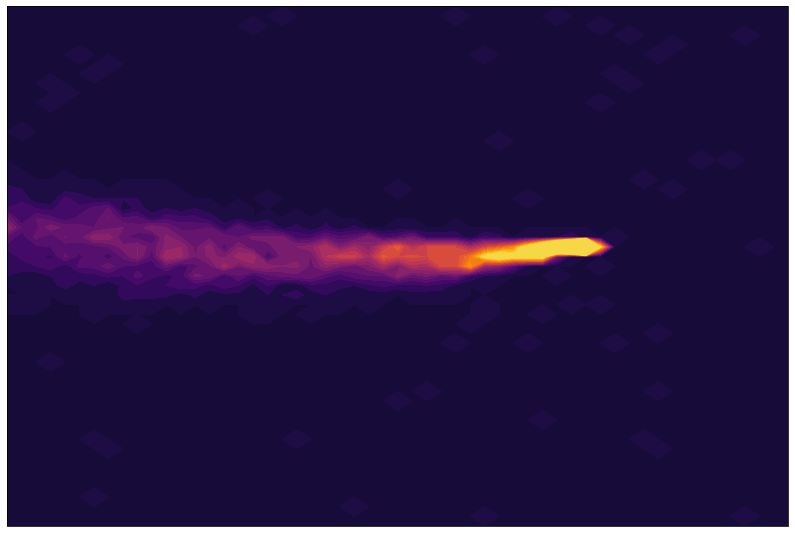

In [ ]:
filepath = "/home/gar/Documents/Devel/hugs/raw_data/TMB-10magl_HR_UKV_EUROPE_201907.nc"

ds = xr.open_dataset(filepath)

domain = "EUROPE"

fp_name = "fp_high"
lon_name = "lon_high"
lat_name = "lat_high"

long_values = ds[fp_name][lon_name]
lat_values = ds[fp_name][lat_name]
zero_values = ds[fp_name][:, :, 0]

zero_mod = zero_values#.where(zero_values > 0.000001)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax = fig.add_subplot(111, projection=ccrs.Mercator(), frameon=False)

ax.add_feature(BORDERS, edgecolor="0.5")

# ax.set_extent((-0.5,0.3, 51,52),crs=ccrs.PlateCarree())

viridisBig = cm.get_cmap('inferno', 512)
lowViridis = ListedColormap(viridisBig(np.linspace(0.1, 0.9, 256)))

cmap = cm.get_cmap("magma")

levels = np.linspace(np.percentile(ds[fp_name].values, 5), np.percentile(ds[fp_name].values, 99.5), 20)

p = ax.contourf(long_values, lat_values, zero_mod, levels=levels, cmap=lowViridis, extend="both")
# p.set_clim(zero_mod.min(), zero_mod.max())

# ax.coastlines(color="white")

plt.savefig(fname="high_res_london_whole.png", dpi=600, pad_inches=0)

In [ ]:
zero_mod

<xarray.DataArray 'fp_high' (lat_high: 55, lon_high: 55)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time      datetime64[ns] 2019-07-01
  * lat_high  (lat_high) float32 50.87064 50.891914 ... 51.998093 52.019367
  * lon_high  (lon_high) float32 -1.260002 -1.228002 ... 0.4359981 0.46799812

In [ ]:
zero_mod["lon_high"].where(zero_mod)

<xarray.DataArray 'lon_high' (lon_high: 55, lat_high: 55)>
array([[-1.260002  , -1.260002  , -1.260002  , ..., -1.260002  ,
        -1.260002  , -1.260002  ],
       [-1.228002  , -1.228002  , -1.228002  , ..., -1.228002  ,
        -1.228002  , -1.228002  ],
       [-1.196002  , -1.196002  , -1.196002  , ..., -1.196002  ,
        -1.196002  , -1.196002  ],
       ...,
       [ 0.4039981 ,  0.4039981 ,  0.4039981 , ...,  0.4039981 ,
         0.4039981 ,  0.4039981 ],
       [ 0.4359981 ,  0.4359981 ,  0.4359981 , ...,  0.4359981 ,
         0.4359981 ,  0.4359981 ],
       [ 0.46799812,  0.46799812,  0.46799812, ...,  0.46799812,
         0.46799812,  0.46799812]], dtype=float32)
Coordinates:
    time      datetime64[ns] 2019-07-01
  * lon_high  (lon_high) float32 -1.260002 -1.228002 ... 0.4359981 0.46799812
  * lat_high  (lat_high) float32 50.87064 50.891914 ... 51.998093 52.019367
Attributes:
    units:    Degrees_east

In [ ]:
print(lat_values.max())

<xarray.DataArray 'lat_high' ()>
array(52.019367, dtype=float32)


In [ ]:
print(lat_values.min())

<xarray.DataArray 'lat_high' ()>
array(50.87064, dtype=float32)


In [ ]:
print(long_values.max())

<xarray.DataArray 'lon_high' ()>
array(0.46799812, dtype=float32)


In [ ]:
print(long_values.min())

<xarray.DataArray 'lon_high' ()>
array(-1.260002, dtype=float32)


In [ ]:
print(zero_mod)

<xarray.DataArray 'fp_high' (lat_high: 55, lon_high: 55)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time      datetime64[ns] 2019-07-01
  * lat_high  (lat_high) float32 50.87064 50.891914 ... 51.998093 52.019367
  * lon_high  (lon_high) float32 -1.260002 -1.228002 ... 0.4359981 0.46799812
